# Seatle Airbnb Base 

AirBnb revolutionized the hospitality market, with its arrival it became easy to reserved rooms or apartments in an easy and practical way between people. The Platform allows anyone to register an accommodation and accept booking proposals from other members.

With this new possibility, a new investment niche has emerged, in which the investor buys apartments, houses and rooms in general to transform them into AirBnb accommodations.
For these investors, understanding what has been working within the platform becomes something very rich. Thus, this article aims to give some tips for anyone interested in investing in accommodation in Seattle, they are:
- Is there seasonality in bookings?
- What are the best places to stay in Seattle?
- How can we predict a competitive value for new accommodation in Seattle?

## Import modules and bases

In [1]:
#Importing Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
#Import calendar.csv as df_cal
df_cal = pd.read_csv("calendar.csv")

#Import listings.csv as df_list
df_list = pd.read_csv("listings.csv")

#Import reviews.csv as df_list
df_revi = pd.read_csv("reviews.csv")

## Question 1 - There are some sazonalitity in reservations?

### Data Understanding and Data Preparation

In [3]:
df_cal.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


As we have the value as "object" it will be necessary to create a function to adjust the field to "float"

In [11]:
def dollar_float(x):
    '''
    returns only the numbers of monetary values
    input: dollar value with string dtype
    output: value in float
    '''
    if type(x)==str:
        x=x[1:].replace(",","")
        x=float(x)
    return x

In addition to adjusting the price, I also realized the need to create more date fields, to be able to handle them satisfactorily.

In [12]:
#format dates
df_cal['date'] = pd.to_datetime(df_cal['date'],
                                format="%Y-%m-%d")
df_cal['year'] = df_cal['date'].dt.year
df_cal['month'] = df_cal['date'].dt.month
df_cal['month_name'] = df_cal['date'].dt.month_name()
df_cal['day'] = df_cal['date'].dt.day
df_cal['day_name'] = df_cal['date'].dt.day_name()
df_cal['day_num'] = df_cal['date'].dt.weekday

#format available and price
df_cal['available'] = df_cal['available'].apply(lambda x:1 if x =='t' else 0)
df_cal['price'] = df_cal['price'].apply(lambda x: dollar_float(x))


In [50]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  int64         
 3   price       934542 non-null   float64       
 4   year        1393570 non-null  int64         
 5   month       1393570 non-null  int64         
 6   month_name  1393570 non-null  object        
 7   day         1393570 non-null  int64         
 8   day_name    1393570 non-null  object        
 9   day_num     1393570 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(2)
memory usage: 106.3+ MB


### Data Modeling and Result Evaluation
Como temos dados de todas os ids de acomodações e nosso foco é entender a sazonalidade, será necessário criar uma pivot table considerando como index a data. Tambem será calculado a Taxa de Reserva e a média de preço.

In [62]:
#Creating a Pivot table with date aggregation
df_calc = df_cal.pivot_table(values=['available','price','listing_id'], 
                             index=['year','month','day','day_name'],
                             aggfunc={'available': np.sum,
                                      'price': np.mean,
                                      'listing_id': len})
df_calc.reset_index(inplace=True) #Date as Index

#Renames Columns
df_calc.rename(columns = {'price':'price_mean', 
                          'listing_id':'num_acomodations',
                          'available':'reserved'}, 
                          inplace = True)

#New columns
df_calc["free"] = df_calc["num_acomodations"] - df_calc["reserved"] 
df_calc["reserved_rate"]= (df_calc["reserved"]/df_calc["num_acomodations"])
df_calc["available_rate"]= (df_calc["free"]/df_calc["num_acomodations"])


#Filter only 2016
df_calc = df_calc[df_calc['year'] == 2016]
df_calc.head()

,year,month,day,day_name,reserved,num_acomodations,price_mean,free,reserved_rate,available_rate
0,2016,1,4,Monday,1735,3818,122.085879,2083,0.454426,0.545574
1,2016,1,5,Tuesday,1867,3818,120.681307,1951,0.488999,0.511001
2,2016,1,6,Wednesday,1826,3818,120.928258,1992,0.478261,0.521739
3,2016,1,7,Thursday,1776,3818,120.958896,2042,0.465165,0.534835
4,2016,1,8,Friday,1782,3818,127.640853,2036,0.466737,0.533263


<AxesSubplot:xlabel='month', ylabel='price_mean'>

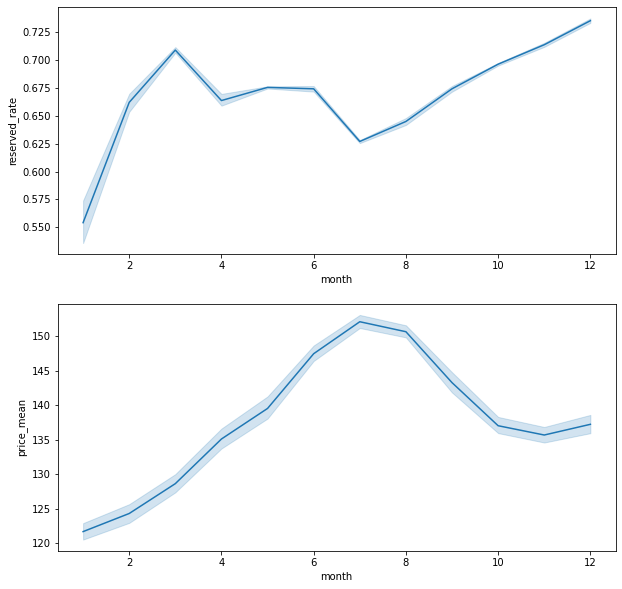

In [52]:
#Graph of Rerverved Rate and Price Mean by Month over the year

fig, ax = plt.subplots(2,figsize=(10,10),sharex = False)
sns.lineplot(data=df_calc, 
             x="month", 
             y="reserved_rate",
             ax=ax[0])

sns.lineplot(data=df_calc, 
             x="month", 
             y="price_mean",
             ax=ax[1])

<AxesSubplot:xlabel='month', ylabel='reserved_rate'>

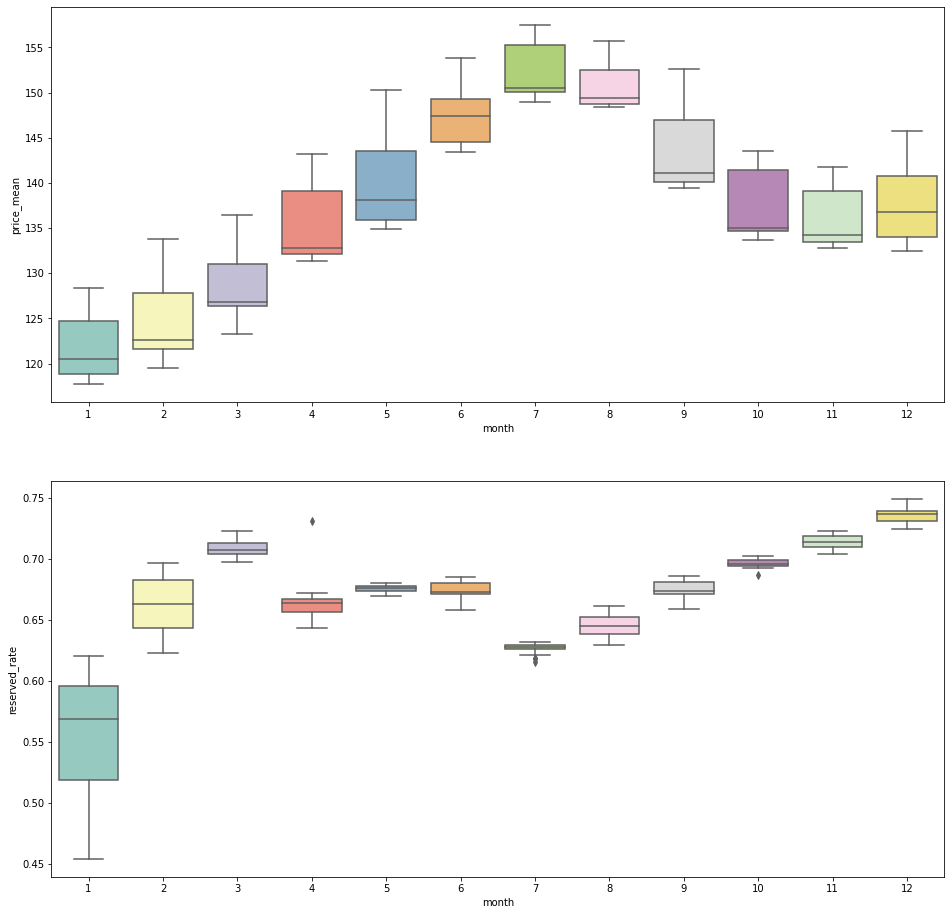

In [57]:
#Boxplot of Rerverved Rate and Price Mean by Month over the year
fig, ax = plt.subplots(2,figsize=(16,16),sharex = False)
sns.boxplot(x='month',
            y='price_mean',
            data=df_calc,
            orient='v',
            palette="Set3",
            ax=ax[0]
            )

sns.boxplot(x='month',
            y='reserved_rate',
            data=df_calc,
            orient='v',
            palette="Set3",
            ax=ax[1]
            )

In the analysis, it was observed that Seattle appears to have a uniform reservation rate between the year 2016.

We have two main peaks, in March and in December, with the arrival of the holiday season. As for the average price, we have an increase in this average during the period from June to August, when the school holidays are on.
So, the tip here is that when investing in Seattle, the investor can expect a good reserve rate and a slightly higher turnover at the end of the year.

I tried to understand the correlation between the metrics to see if something could be impacting the price average.

In [25]:
#Correlation between collumns
columns = ['free', 'price_mean','reserved', 'reserved_rate', 'available_rate']
for col in columns:
    cor = df_calc['price_mean'].corr(df_calc[col])
    print(col,cor)

free -0.06244029369430978
price_mean 1.0
reserved 0.06244029369430978
reserved_rate 0.06244029369430973
available_rate -0.062440293694309486


However, we did not identify any high correlation.

Finally, I tried to understand the average price between the days of the week.

<AxesSubplot:xlabel='day_name', ylabel='reserved_rate'>

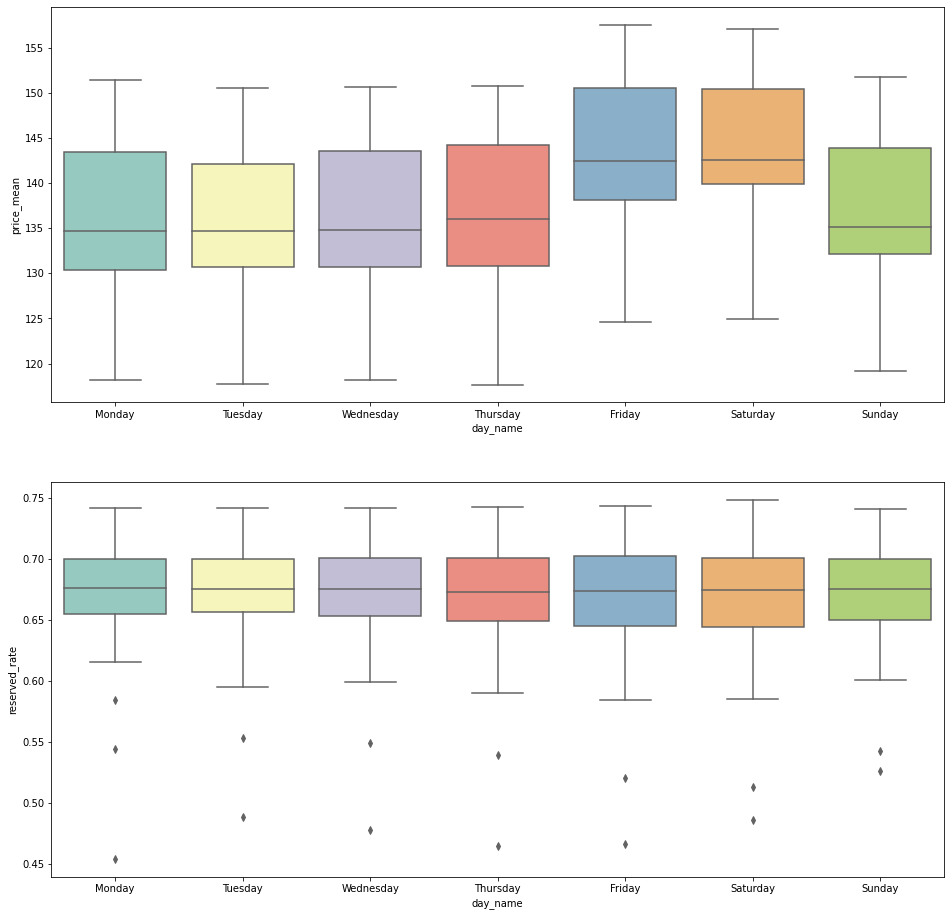

In [59]:
#Boxplot of Rerverved Rate and Price Mean by Month over the year
fig, ax = plt.subplots(2,figsize=(16,16),sharex = False)
sns.boxplot(x='day_name',
            y='price_mean',
            data=df_calc,
            orient='v',
            palette="Set3",
            ax=ax[0]
            )

sns.boxplot(x='day_name',
            y='reserved_rate',
            data=df_calc,
            orient='v',
            palette="Set3",
            ax=ax[1]
            )

I noticed that on Fridays and Saturdays this value goes up considerably.

### Learnings

- Seatle seems to be busy in all the months, but the Reverved Rate are big on march and december (on holiday).
- However the price mean doesn't seems to a big correlation with de Reverved Rate, the correlation is only 0.06. The highster price mean is in july, month that we have the one of de lowest reserved rate. This behavior suggests that price is not of the most requesites for a reservations.
- The highter mean price ocorring on Fridays and Saturdays and the reserved rate seems to be equal beetween the days of the week.

## Question 2 - Where is the Best Place to have a acomodation in Seatle?

### Data Understanding and Data Preparation

In [28]:
df_cal.head()

,listing_id,date,available,price,year,month,month_name,day,day_name,day_num
0,241032,2016-01-04,1,85.0,2016,1,January,4,Monday,0
1,241032,2016-01-05,1,85.0,2016,1,January,5,Tuesday,1
2,241032,2016-01-06,0,NaN,2016,1,January,6,Wednesday,2
3,241032,2016-01-07,0,NaN,2016,1,January,7,Thursday,3
4,241032,2016-01-08,0,NaN,2016,1,January,8,Friday,4


To understand the best neighborhoods in Seattle, it will be necessary to search the df_list for the fields related to addresses and cross them with the df_cal.

In [29]:
#Filtering fields related to addresses 
col_adress = ['id','zipcode','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed']

In [30]:
#Filtering the adress columns in df_list
col_adress = ['id','zipcode','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed']
df_list_add = df_list[col_adress]
df_list_add = df_list_add.rename(columns={'id':'listing_id'}) #Rename 'id' column by the same name to df_cal
df_list_add.head()

,listing_id,zipcode,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,241032,98119,Queen Anne,West Queen Anne,Queen Anne
1,953595,98119,Queen Anne,West Queen Anne,Queen Anne
2,3308979,98119,Queen Anne,West Queen Anne,Queen Anne
3,7421966,98119,Queen Anne,West Queen Anne,Queen Anne
4,278830,98119,Queen Anne,West Queen Anne,Queen Anne


In [31]:
#Left Join between the two bases
df_cal_ng = pd.merge(df_cal,df_list_add, on='listing_id', how='left')
df_cal_ng

,listing_id,date,available,price,year,month,month_name,day,day_name,day_num,zipcode,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,241032,2016-01-04,1,85.0,2016,1,January,4,Monday,0,98119,Queen Anne,West Queen Anne,Queen Anne
1,241032,2016-01-05,1,85.0,2016,1,January,5,Tuesday,1,98119,Queen Anne,West Queen Anne,Queen Anne
2,241032,2016-01-06,0,NaN,2016,1,January,6,Wednesday,2,98119,Queen Anne,West Queen Anne,Queen Anne
3,241032,2016-01-07,0,NaN,2016,1,January,7,Thursday,3,98119,Queen Anne,West Queen Anne,Queen Anne
4,241032,2016-01-08,0,NaN,2016,1,January,8,Friday,4,98119,Queen Anne,West Queen Anne,Queen Anne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393565,10208623,2016-12-29,0,NaN,2016,12,December,29,Thursday,3,98109,Queen Anne,East Queen Anne,Queen Anne
1393566,10208623,2016-12-30,0,NaN,2016,12,December,30,Friday,4,98109,Queen Anne,East Queen Anne,Queen Anne
1393567,10208623,2016-12-31,0,NaN,2016,12,December,31,Saturday,5,98109,Queen Anne,East Queen Anne,Queen Anne
1393568,10208623,2017-01-01,0,NaN,2017,1,January,1,Sunday,6,98109,Queen Anne,East Queen Anne,Queen Anne


### Data Modeling and Result Evaluation
Then it will be necessary to create a pivot table, placing as an index the groupings of neighborhoods that we would like to analyze.

In [66]:
#Creating a Pivot table with neighbourhood_group_cleansed
df_cal_ng['listing_id2'] = df_cal_ng['listing_id']
df_calc_ng = df_cal_ng.pivot_table(values=['available','price','listing_id','listing_id2'], 
                             index=['neighbourhood_group_cleansed'],
                             aggfunc={'available': np.sum,
                                      'price': np.mean,
                                      'listing_id': len,
                                      'listing_id2': lambda x: len(x.unique())})
df_calc_ng.reset_index(inplace=True) #Date as Index
#Renames Columns
df_calc_ng.rename(columns = {'price':'price_mean', 
                          'listing_id':'num_acomodations',
                          'available':'reserved',
                          'listing_id2':'ids'}, 
                          inplace = True)

#New columns
df_calc_ng["free"] = df_calc_ng["num_acomodations"] - df_calc_ng["reserved"] 
df_calc_ng["reserved_rate"]= (df_calc_ng["reserved"]/df_calc_ng["num_acomodations"])
df_calc_ng["available_rate"]= (df_calc_ng["free"]/df_calc_ng["num_acomodations"])
df_calc_ng.sort_values(by=['reserved_rate'], ascending = False).head(10)

,neighbourhood_group_cleansed,reserved,num_acomodations,ids,price_mean,free,reserved_rate,available_rate
7,Interbay,3394,4015,11,118.421037,621,0.845330,0.154670
9,Magnolia,17248,22265,61,198.694341,5017,0.774669,0.225331
8,Lake City,18801,24455,67,94.518589,5654,0.768800,0.231200
5,Delridge,21545,28835,79,90.926944,7290,0.747182,0.252818
15,University District,33148,44530,122,104.709937,11382,0.744397,0.255603
10,Northgate,21105,29200,80,93.455532,8095,0.722774,0.277226
1,Beacon Hill,30270,43070,118,100.668781,12800,0.702809,0.297191
16,West Seattle,51950,74095,203,148.155804,22145,0.701127,0.298873
0,Ballard,58115,83950,230,125.905980,25835,0.692257,0.307743
14,Seward Park,10921,16060,44,111.110338,5139,0.680012,0.319988


In [67]:
df_calc_ng.describe()

,reserved,num_acomodations,ids,price_mean,free,reserved_rate,available_rate
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,54973.058824,81974.705882,224.588235,129.373173,27001.647059,0.698910,0.301090
std,52581.021189,80463.674519,220.448423,33.654305,28052.268360,0.064556,0.064556
min,3394.000000,4015.000000,11.000000,90.926944,621.000000,0.576174,0.154670
25%,18801.000000,28835.000000,79.000000,100.668781,7290.000000,0.670526,0.255603
50%,33148.000000,44530.000000,122.000000,125.622015,13768.000000,0.692257,0.307743
75%,66804.000000,107675.000000,295.000000,148.155804,40871.000000,0.744397,0.329474
max,194661.000000,289810.000000,794.000000,198.694341,95149.000000,0.845330,0.423826


When trying to understand which would be the main neighborhoods to invest in Seattle, we observed that the reservation rate does not change that much, but we have a large variation in the average price between neighborhoods. Thus, the main neighborhood to invest in, taking into account the average price, booking fee and the number of accommodations is Magnolia.

I also analyzed a smaller cluster.

In [64]:
#Creating a Pivot table with neighbourhood_cleansed
df_cal_ng['listing_id2'] = df_cal_ng['listing_id']
df_calc_ng = df_cal_ng.pivot_table(values=['available','price','listing_id','listing_id2'], 
                             index=['neighbourhood_cleansed'],
                             aggfunc={'available': np.sum,
                                      'price': np.mean,
                                      'listing_id': len,
                                      'listing_id2': lambda x: len(x.unique())})
df_calc_ng.reset_index(inplace=True) #Date as Index
#Renames Columns
df_calc_ng.rename(columns = {'price':'price_mean', 
                          'listing_id':'num_acomodations',
                          'available':'reserved',
                          'listing_id2':'ids'}, 
                          inplace = True)

#New columns
df_calc_ng["free"] = df_calc_ng["num_acomodations"] - df_calc_ng["reserved"] 
df_calc_ng["reserved_rate"]= (df_calc_ng["reserved"]/df_calc_ng["num_acomodations"])
df_calc_ng["available_rate"]= (df_calc_ng["free"]/df_calc_ng["num_acomodations"])
df_calc_ng.sort_values(by=['reserved_rate'], ascending = False)

,neighbourhood_cleansed,reserved,num_acomodations,ids,price_mean,free,reserved_rate,available_rate
31,Holly Park,2128,2190,6,148.137688,62,0.971689,0.028311
66,Roxhill,696,730,2,122.162356,34,0.953425,0.046575
29,High Point,4822,5110,14,106.236002,288,0.943640,0.056360
30,Highland Park,3510,4015,11,89.253561,505,0.874222,0.125778
6,Briarcliff,4422,5110,14,216.080733,688,0.865362,0.134638
...,...,...,...,...,...,...,...,...
64,Riverview,1589,2920,8,81.707363,1331,0.544178,0.455822
67,Seaview,2291,4380,12,136.501091,2089,0.523059,0.476941
51,North Beach/Blue Ridge,2626,5110,14,122.317212,2484,0.513894,0.486106
69,South Beacon Hill,733,1460,4,90.968622,727,0.502055,0.497945


I plotted a graph to make it clear how booking rates were similar

<AxesSubplot:xlabel='num_acomodations', ylabel='reserved'>

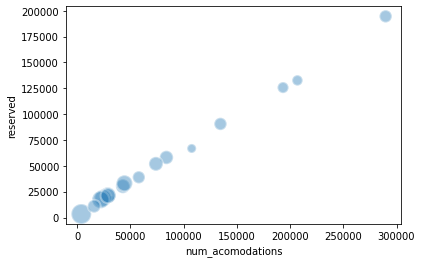

In [34]:
sns.scatterplot(data= df_calc_ng,
                x = 'num_acomodations',
                y = 'reserved',
                size = 'reserved_rate',
                legend = False,
                sizes = (20, 400),
                cmap = 'Blues',
                alpha = 0.4,
                edgecolors = 'grey',
                linewidth = 2)


### Learnings
- The Reserved Rate when we look at neighbourhood_cleansed seems to be really similar, with a standard deviation with 0.06455. However Price Mean seems to have more variation, with standard deviation as 33.65.
- With this information, the main neighborhood to invest in seems to be Magnolia, with the best average price and second best Reserved Rate.

## Question 3 - How can we predict a competitive value for new accommodation in Seattle?

### Data Understanding and Data Preparation

In [35]:
df_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


To predict a competitive price for a new accommodation, a linear regression will be performed considering the following elements from the AirBnb database: accommodations, bathrooms, bedrooms, beds, weekly_price, monthly price, security deposit, cleaning fee, instant bookable, reviews per month , extra people, cancellation policy, neighborhood group cleaned.

To select the main features, several tests were carried out to understand the fields that most influenced the price and maximize the test_score.

In [36]:
#Filtering the base with the main measurements for the prediction of the value of the acomodation
features = ['price','accommodates','bathrooms','bedrooms','beds','weekly_price','monthly_price',
            'security_deposit','cleaning_fee', 'instant_bookable','reviews_per_month','extra_people',
            'cancellation_policy','neighbourhood_group_cleansed']
df_list_feat = df_list[features].copy()
df_list_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price                         3818 non-null   object 
 1   accommodates                  3818 non-null   int64  
 2   bathrooms                     3802 non-null   float64
 3   bedrooms                      3812 non-null   float64
 4   beds                          3817 non-null   float64
 5   weekly_price                  2009 non-null   object 
 6   monthly_price                 1517 non-null   object 
 7   security_deposit              1866 non-null   object 
 8   cleaning_fee                  2788 non-null   object 
 9   instant_bookable              3818 non-null   object 
 10  reviews_per_month             3191 non-null   float64
 11  extra_people                  3818 non-null   object 
 12  cancellation_policy           3818 non-null   object 
 13  nei

The money fields have all been adjusted

In [37]:
#Convert dollar dtype to float
df_list_feat['price']            = df_list_feat['price'].apply(lambda x: dollar_float(x))
df_list_feat['monthly_price']    = df_list_feat['monthly_price'].apply(lambda x: dollar_float(x))
df_list_feat['weekly_price']     = df_list_feat['weekly_price'].apply(lambda x: dollar_float(x))
df_list_feat['security_deposit'] = df_list_feat['security_deposit'].apply(lambda x: dollar_float(x))
df_list_feat['cleaning_fee']     = df_list_feat['cleaning_fee'].apply(lambda x: dollar_float(x))
df_list_feat['extra_people']     = df_list_feat['extra_people'].apply(lambda x: dollar_float(x))

df_list_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price                         3818 non-null   float64
 1   accommodates                  3818 non-null   int64  
 2   bathrooms                     3802 non-null   float64
 3   bedrooms                      3812 non-null   float64
 4   beds                          3817 non-null   float64
 5   weekly_price                  2009 non-null   float64
 6   monthly_price                 1517 non-null   float64
 7   security_deposit              1866 non-null   float64
 8   cleaning_fee                  2788 non-null   float64
 9   instant_bookable              3818 non-null   object 
 10  reviews_per_month             3191 non-null   float64
 11  extra_people                  3818 non-null   float64
 12  cancellation_policy           3818 non-null   object 
 13  nei

#### Missing values for numberic variables

For numeric fields missing values, a population mean was considered since we have a high value of fields with values.

In [38]:
nume = df_list_feat.select_dtypes(include=['int','float']).columns
for col in nume:
    df_list_feat.loc[:,col] = df_list_feat[col].fillna(df_list_feat[col].mean())

    
df_list_feat[nume].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              3818 non-null   float64
 1   accommodates       3818 non-null   int64  
 2   bathrooms          3818 non-null   float64
 3   bedrooms           3818 non-null   float64
 4   beds               3818 non-null   float64
 5   weekly_price       3818 non-null   float64
 6   monthly_price      3818 non-null   float64
 7   security_deposit   3818 non-null   float64
 8   cleaning_fee       3818 non-null   float64
 9   reviews_per_month  3818 non-null   float64
 10  extra_people       3818 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 328.2 KB


#### Missing values for categorical variables
For the categorical fields, all were turned into dummies.

In [68]:
cate = df_list_feat.select_dtypes(include=['object','bool']).columns
for col in cate:
    df_list_feat = pd.concat([df_list_feat.drop(col, axis=1), pd.get_dummies(df_list_feat[col], prefix=col, prefix_sep='_', drop_first=True)],
                         axis=1)

In [69]:
df_list_feat.head()

,price,accommodates,bathrooms,bedrooms,beds,weekly_price,monthly_price,security_deposit,cleaning_fee,reviews_per_month,...,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle
0,85.0,4,1.0,1.0,1.0,788.481832,2613.33619,287.610397,61.710904,4.070000,...,0,0,0,0,0,1,0,0,0,0
1,150.0,4,1.0,1.0,1.0,1000.000000,3000.00000,100.000000,40.000000,1.480000,...,0,0,0,0,0,1,0,0,0,0
2,975.0,11,4.5,5.0,7.0,788.481832,2613.33619,1000.000000,300.000000,1.150000,...,0,0,0,0,0,1,0,0,0,0
3,100.0,3,1.0,0.0,2.0,650.000000,2300.00000,287.610397,61.710904,2.078919,...,0,0,0,0,0,1,0,0,0,0
4,450.0,6,2.0,3.0,3.0,788.481832,2613.33619,700.000000,125.000000,0.890000,...,0,0,0,0,0,1,0,0,0,0


### Data Modeling and Result Evaluation

The correlation was calculated so that we can begin to understand the relevance of the fields to each other.

Correlation among numeric variables: 

price                                               1.000000
accommodates                                        0.652218
bathrooms                                           0.516017
bedrooms                                            0.627596
beds                                                0.589306
weekly_price                                        0.626361
monthly_price                                       0.495664
security_deposit                                    0.294389
cleaning_fee                                        0.583274
reviews_per_month                                  -0.199620
extra_people                                        0.127961
instant_bookable_t                                 -0.031712
cancellation_policy_moderate                       -0.102123
cancellation_policy_strict                          0.226632
neighbourhood_group_cleansed_Beacon Hill           -0.065915
neighbourhood_group_cleansed_Capitol Hill     

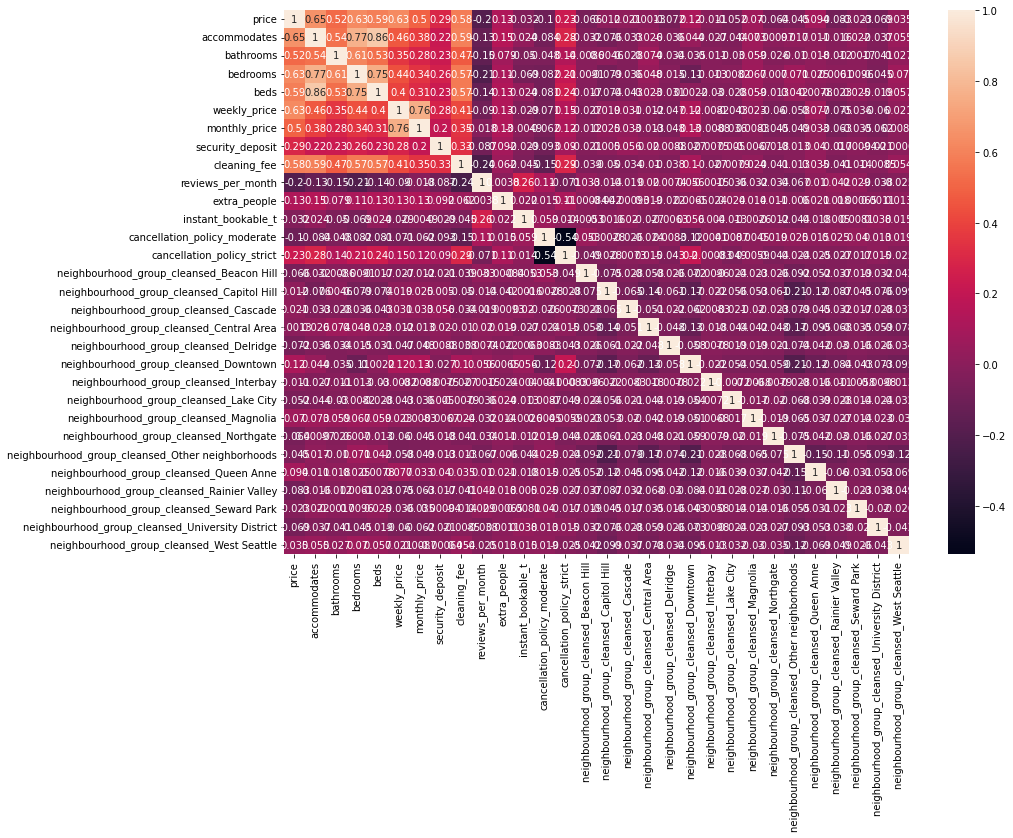

In [41]:
print('Correlation among numeric variables: \n')

plt.figure(figsize=(14,10))
corr = df_list_feat.corr()
print(corr['price'], '\n')

print('Present the result in heatmap: ')
sns.heatmap(corr, annot=True)
plt.show()

Put the data in the Linear Regression Algorithm

In [71]:
y = df_list_feat['price'] 
X = df_list_feat.drop(columns = ['price'], inplace=False)

In [72]:
#Splitting data between training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Choosing the model
lm_model = LinearRegression(normalize = True)
lm_model.fit(X_train, y_train)

#Calculating the training and test Y
y_test_predict = lm_model.predict(X_test)
y_train_predict = lm_model.predict(X_train)

#Calculating the scores
test_score = r2_score(y_test, y_test_predict)
train_score = r2_score(y_train, y_train_predict)

/Users/jeffsantos/Desktop/SeatleAirBnb/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [44]:
# Printing thee model evaluation scores for training and test
print('Traning Data:')
print('r-sqaured score: %.3f' % r2_score(y_train, y_train_predict))
print('mean-sqaured error: %.3f' % mean_squared_error(y_train, y_train_predict))
print('---')
print('Test Data:')
print('r-sqaured score: %.3f' % r2_score(y_test, y_test_predict))
print('mean-sqaured error: %.3f' % mean_squared_error(y_test, y_test_predict))
print('---')

Traning Data:
r-sqaured score: 0.634
mean-sqaured error: 2913.669
---
Test Data:
r-sqaured score: 0.630
mean-sqaured error: 3170.736
---


In the model created, we were able to reach an r-square of 0.63, a good value that guarantees that the model works to help new investors when determining the price of their property. We were also able to measure which elements among those chosen have the greatest impact when setting the price.

Rank features by their impact on the price: 
                                              feature       coef   abs_coef
21             neighbourhood_group_cleansed_Magnolia  30.634394  30.634394
18             neighbourhood_group_cleansed_Downtown  25.370593  25.370593
24           neighbourhood_group_cleansed_Queen Anne  23.339539  23.339539
15              neighbourhood_group_cleansed_Cascade  21.544635  21.544635
22            neighbourhood_group_cleansed_Northgate -18.647682  18.647682
14         neighbourhood_group_cleansed_Capitol Hill  16.397243  16.397243
1                                          bathrooms  16.204129  16.204129
2                                           bedrooms  15.583924  15.583924
17             neighbourhood_group_cleansed_Delridge -14.817918  14.817918
25       neighbourhood_group_cleansed_Rainier Valley -14.384731  14.384731
20            neighbourhood_group_cleansed_Lake City -13.710172  13.710172
13          neighbourhood_group_cleansed_Beacon Hill -

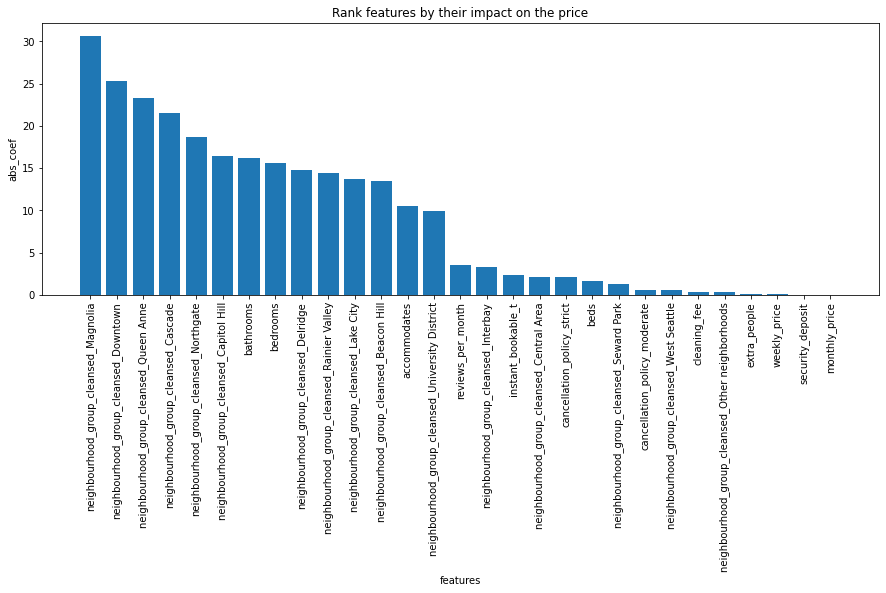

In [45]:
coef_df = pd.DataFrame()
coef_df['feature'] = X_train.columns
coef_df['coef'] = lm_model.coef_
coef_df['abs_coef'] = np.abs(lm_model.coef_)
coef_df = coef_df.sort_values(by=['abs_coef'], ascending=False)
print('Rank features by their impact on the price: \n', coef_df, '\n')

plt.figure(figsize = (15,5))
plt.bar(coef_df['feature'], coef_df['abs_coef'])
plt.xlabel('features')
plt.xticks(coef_df['feature'], rotation = 90)
plt.ylabel('abs_coef')
plt.title('Rank features by their impact on the price')
plt.show()

As we can see, the main elements are related to the neighborhood in which the accommodation is located. Regarding the characteristic of the accommodation, the ones that stand out are the bathrooms and bedrooms.

### Learnings
- The location of acomodation is the most relevante feature for a price prediction.
- Bathrooms an Bedroomns are great features two.

# In short

- Question 1: The investor who decides to choose Seattle will have a good reserve rate and can expect a good financial return at the end of the year.
- Question 2: The main neighborhood to invest in is Magnolia.
- Question 3: Thinking of increasing his reservation price, he should invest in accommodations with more bathrooms and bedrooms.